In [2]:
import pandas as pd


In [9]:
df = pd.read_csv("/content/final_MERGED_dataset (2).csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585495 entries, 0 to 585494
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UNNAMED:_0                585495 non-null  int64  
 1   ROUTENO                   585495 non-null  int64  
 2   ROUTE_DESCRIPTION         585495 non-null  object 
 3   Full Date                 585495 non-null  object 
 4   FORMATTEDDATE             585495 non-null  object 
 5   SKU                       585495 non-null  int64  
 6   SKU_DESCRIPTION           585495 non-null  object 
 7   Retailer                  585495 non-null  object 
 8   CUSTOMER_ACCT             585495 non-null  object 
 9   STORE_ADDRESS             585495 non-null  object 
 10  STORE_CITY                585495 non-null  object 
 11  STORE_STATE               585495 non-null  object 
 12  GROSS_DOLLARS             585495 non-null  float64
 13  RETURN_DOLLARS            585495 non-null  f

In [5]:
# Take specified columns
df_new = df[['Full Date', 'SKU', 'Retailer', 'Net Units']].copy()

print(df_new.shape)

df_new = df_new.groupby(['Retailer','SKU','Full Date']).agg({'Net Units': 'sum'}).reset_index()

# Create combo key 'key1'
df_new['key'] = df_new['Retailer'].astype(str) + '_' + df_new['SKU'].astype(str)

# Convert 'RawDate' to datetime
df_new['Full Date'] = pd.to_datetime(df_new['Full Date'])

# Filter data before Jan 2025
df_new = df_new[(df_new['Full Date'] < pd.to_datetime('2025-01-01')) & (df_new['Full Date'] >= pd.to_datetime('2023-07-01'))]
print(df_new.shape)

# Function to create time-continuous data
def make_time_continuous(group):
    min_date = group['Full Date'].min()
    max_date = pd.to_datetime('2024-12-31')
    date_range = pd.date_range(start=min_date, end=max_date)
    continuous_data = pd.DataFrame({'Full Date': date_range})
    continuous_data = continuous_data.merge(group.reset_index(drop =True), on='Full Date', how='left') #.fillna(0)
    categorical_cols = ['SKU', 'Retailer', 'key']  # Adjust based on your dataset
    continuous_data[categorical_cols] = continuous_data[categorical_cols].ffill()
    continuous_data['Net Units'] = continuous_data['Net Units'].fillna(0)
    return continuous_data

# Apply the function
df_continuous = df_new.groupby('key',group_keys=False).apply(make_time_continuous).reset_index(drop=True)
print(df_continuous.shape)
print("executed successfully")

(22624, 4)
(0, 5)
(0, 5)
executed successfully


<ipython-input-5-a7fb2b639e89>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_continuous = df_new.groupby('key',group_keys=False).apply(make_time_continuous).reset_index(drop=True)


In [ ]:
df_continuous.columns = ['date','retailer','sku','netsales','key']
df_continuous

,date,retailer,sku,netsales,key
0,2024-03-05,CLARK`S MARKET,2040.0,-1.0,CLARK`S MARKET_2040
1,2024-03-06,CLARK`S MARKET,2040.0,0.0,CLARK`S MARKET_2040
2,2024-03-07,CLARK`S MARKET,2040.0,0.0,CLARK`S MARKET_2040
3,2024-03-08,CLARK`S MARKET,2040.0,2.0,CLARK`S MARKET_2040
4,2024-03-09,CLARK`S MARKET,2040.0,0.0,CLARK`S MARKET_2040
...,...,...,...,...,...
67500,2024-12-27,WHOLE FOODS MARKET (CO),9432.0,0.0,WHOLE FOODS MARKET (CO)_9432
67501,2024-12-28,WHOLE FOODS MARKET (CO),9432.0,0.0,WHOLE FOODS MARKET (CO)_9432
67502,2024-12-29,WHOLE FOODS MARKET (CO),9432.0,0.0,WHOLE FOODS MARKET (CO)_9432
67503,2024-12-30,WHOLE FOODS MARKET (CO),9432.0,0.0,WHOLE FOODS MARKET (CO)_9432


In [ ]:
maindf = df_continuous[['key','date','netsales']]
maindf

,key,date,netsales
0,CLARK`S MARKET_2040,2024-03-05,-1.0
1,CLARK`S MARKET_2040,2024-03-06,0.0
2,CLARK`S MARKET_2040,2024-03-07,0.0
3,CLARK`S MARKET_2040,2024-03-08,2.0
4,CLARK`S MARKET_2040,2024-03-09,0.0
...,...,...,...
67500,WHOLE FOODS MARKET (CO)_9432,2024-12-27,0.0
67501,WHOLE FOODS MARKET (CO)_9432,2024-12-28,0.0
67502,WHOLE FOODS MARKET (CO)_9432,2024-12-29,0.0
67503,WHOLE FOODS MARKET (CO)_9432,2024-12-30,0.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#### EXPO SMOOTHING
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming 'maindf' is already loaded with columns ['key', 'date', 'netsales']
maindf['date'] = pd.to_datetime(maindf['date'])  # Convert to datetime format

# Splitting the dataset
train_cutoff = pd.to_datetime("2024-10-01")
keys_with_enough_data = []
keys_insufficient_data = []

all_results = []  # List to store detailed results

# Iterate through each unique key
for key in maindf['key'].unique():
    df_key = maindf[maindf['key'] == key].sort_values('date').set_index('date').asfreq('D')  # Set 'date' as index

    # Split into train and test
    train_data = df_key[df_key.index < train_cutoff]
    test_data = df_key[df_key.index >= train_cutoff]

    # Ensure at least 100 days of history
    if len(train_data) < 100:
        keys_insufficient_data.append(key)
        continue  # Skip to next key

    keys_with_enough_data.append(key)

    # Model training
    model = ExponentialSmoothing(
        train_data['netsales'],
        seasonal='add',
        seasonal_periods=7,  # Weekly seasonality
        trend='add'
    ).fit()

    # Forecasting for test period
    forecast_dates = test_data.index  # Use same dates as test period
    predictions = pd.Series(model.forecast(len(test_data)), index=forecast_dates)

    # Compute error metrics
    mae = mean_absolute_error(test_data['netsales'], predictions)
    r2 = r2_score(test_data['netsales'], predictions)

    # Store results in a structured format
    results_df = pd.DataFrame({
        'key': key,
        'date': forecast_dates,
        'predictions': predictions.values,
        'actuals': test_data['netsales'].values
    })
    results_df['mae'] = mae
    results_df['r2'] = r2

    all_results.append(results_df)

# Combine all key results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)


# Print keys that were insufficient
print("Keys with insufficient data:", keys_insufficient_data)

final_results_df['predictions'] = final_results_df['predictions'].astype(int)

final_results_df['model'] = 'Exponential Smoothing'
final_results_df

Keys with insufficient data: ['CLARK`S MARKET_9531', 'CRAIG HOSPITAL_9450', 'KING SOOPERS_7088', 'KING SOOPERS_9432', 'KING SOOPERS_9450', 'KING SOOPERS_9502', 'KING SOOPERS_9530', 'KING SOOPERS_9605', 'LUCKY`S MARKET_9450', 'LUCKY`S MARKET_9500', 'LUCKY`S MARKET_9502', 'LUCKY`S MARKET_9504', 'LUCKY`S MARKET_9530', 'LUCKY`S MARKET_9602', 'NIWOT MARKET_6004', 'SPROUTS FARMERS MARKET (CO)_6024', 'SPROUTS FARMERS MARKET (CO)_6026', 'SPROUTS FARMERS MARKET (CO)_6044', 'SUPER WAL-MART (CO)_4100', 'SUPER WAL-MART (CO)_4130', 'SUPER WAL-MART (CO)_6006', 'TARGET (VENDOR - 1184860)_6004', 'VITAMIN COTTAGE_6125', 'VITAMIN COTTAGE_9450', 'VITAMIN COTTAGE_9530', 'VITAMIN COTTAGE_9531', 'WHOLE FOODS MARKET (CO)_6004', 'WHOLE FOODS MARKET (CO)_6006', 'WHOLE FOODS MARKET (CO)_6026', 'WHOLE FOODS MARKET (CO)_6044', 'WHOLE FOODS MARKET (CO)_7088', 'WHOLE FOODS MARKET (CO)_9431', 'WHOLE FOODS MARKET (CO)_9432']


,key,date,predictions,actuals,mae,r2,model
0,CLARK`S MARKET_2040,2024-10-01,0,0.0,0.331054,0.435435,Exponential Smoothing
1,CLARK`S MARKET_2040,2024-10-02,0,0.0,0.331054,0.435435,Exponential Smoothing
2,CLARK`S MARKET_2040,2024-10-03,0,0.0,0.331054,0.435435,Exponential Smoothing
3,CLARK`S MARKET_2040,2024-10-04,2,4.0,0.331054,0.435435,Exponential Smoothing
4,CLARK`S MARKET_2040,2024-10-05,0,0.0,0.331054,0.435435,Exponential Smoothing
...,...,...,...,...,...,...,...
19867,WHOLE FOODS MARKET (CO)_8226,2024-12-27,2,0.0,3.487299,0.243351,Exponential Smoothing
19868,WHOLE FOODS MARKET (CO)_8226,2024-12-28,8,0.0,3.487299,0.243351,Exponential Smoothing
19869,WHOLE FOODS MARKET (CO)_8226,2024-12-29,0,0.0,3.487299,0.243351,Exponential Smoothing
19870,WHOLE FOODS MARKET (CO)_8226,2024-12-30,8,0.0,3.487299,0.243351,Exponential Smoothing


In [ ]:
#### Prophet Model

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import logging

logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
# Assuming 'maindf' is already loaded with columns ['key', 'date', 'netsales']
maindf['date'] = pd.to_datetime(maindf['date'])  # Convert to datetime format

# Splitting the dataset
train_cutoff = pd.to_datetime("2024-10-01")
keys_with_enough_data = []
keys_insufficient_data = []

all_results = []  # List to store detailed results

# Iterate through each unique key
for key in maindf['key'].unique():
    df_key = maindf[maindf['key'] == key].sort_values('date').set_index('date').asfreq('D')  # Set date as index

    # Split into train and test
    train_data = df_key[df_key.index < train_cutoff]
    test_data = df_key[df_key.index >= train_cutoff]

    # Ensure at least 100 days of history
    if len(train_data) < 100:
        keys_insufficient_data.append(key)
        continue  # Skip to next key

    keys_with_enough_data.append(key)

    # Prepare data for Prophet (rename columns as required)
    train_data = train_data.reset_index().rename(columns={'date': 'ds', 'netsales': 'y'})
    test_data = test_data.reset_index().rename(columns={'date': 'ds', 'netsales': 'y'})

    # Model Training
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05  # Regularization to prevent overfitting
    )

    model.fit(train_data)

    # Forecasting for test period
    future_dates = pd.DataFrame({'ds': test_data['ds']})
    forecast = model.predict(future_dates)

    # Extract predictions
    predictions = forecast[['ds', 'yhat']].set_index('ds')['yhat']

    # Compute error metrics
    mae = mean_absolute_error(test_data['y'], predictions)
    r2 = r2_score(test_data['y'], predictions)

    # Store results in a structured format
    results_df = pd.DataFrame({
        'key': key,
        'date': test_data['ds'],
        'predictions': predictions.values,
        'actuals': test_data['y'].values
    })
    results_df['mae'] = mae
    results_df['r2'] = r2
    results_df['model'] = 'Prophet'

    all_results.append(results_df)

# Combine all key results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Convert predictions to integers
final_results_df['predictions'] = final_results_df['predictions'].astype(int)

# Print keys that were insufficient
print("Keys with insufficient data:", keys_insufficient_data)
final_results_df

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvx6zucgf/jwncdrzd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvx6zucgf/gsdt6tw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78071', 'data', 'file=/tmp/tmpvx6zucgf/jwncdrzd.json', 'init=/tmp/tmpvx6zucgf/gsdt6tw4.json', 'output', 'file=/tmp/tmpvx6zucgf/prophet_modelkptczbo4/prophet_model-20250214212102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvx6zucgf/5vrpes4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvx6zucgf/pg5zvu5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Keys with insufficient data: ['CLARK`S MARKET_9531', 'CRAIG HOSPITAL_9450', 'KING SOOPERS_7088', 'KING SOOPERS_9432', 'KING SOOPERS_9450', 'KING SOOPERS_9502', 'KING SOOPERS_9530', 'KING SOOPERS_9605', 'LUCKY`S MARKET_9450', 'LUCKY`S MARKET_9500', 'LUCKY`S MARKET_9502', 'LUCKY`S MARKET_9504', 'LUCKY`S MARKET_9530', 'LUCKY`S MARKET_9602', 'NIWOT MARKET_6004', 'SPROUTS FARMERS MARKET (CO)_6024', 'SPROUTS FARMERS MARKET (CO)_6026', 'SPROUTS FARMERS MARKET (CO)_6044', 'SUPER WAL-MART (CO)_4100', 'SUPER WAL-MART (CO)_4130', 'SUPER WAL-MART (CO)_6006', 'TARGET (VENDOR - 1184860)_6004', 'VITAMIN COTTAGE_6125', 'VITAMIN COTTAGE_9450', 'VITAMIN COTTAGE_9530', 'VITAMIN COTTAGE_9531', 'WHOLE FOODS MARKET (CO)_6004', 'WHOLE FOODS MARKET (CO)_6006', 'WHOLE FOODS MARKET (CO)_6026', 'WHOLE FOODS MARKET (CO)_6044', 'WHOLE FOODS MARKET (CO)_7088', 'WHOLE FOODS MARKET (CO)_9431', 'WHOLE FOODS MARKET (CO)_9432']


,key,date,predictions,actuals,mae,r2,model
0,CLARK`S MARKET_2040,2024-10-01,0,0.0,0.552036,0.315685,Prophet
1,CLARK`S MARKET_2040,2024-10-02,0,0.0,0.552036,0.315685,Prophet
2,CLARK`S MARKET_2040,2024-10-03,0,0.0,0.552036,0.315685,Prophet
3,CLARK`S MARKET_2040,2024-10-04,2,4.0,0.552036,0.315685,Prophet
4,CLARK`S MARKET_2040,2024-10-05,0,0.0,0.552036,0.315685,Prophet
...,...,...,...,...,...,...,...
19867,WHOLE FOODS MARKET (CO)_8226,2024-12-27,4,0.0,5.096701,-0.112807,Prophet
19868,WHOLE FOODS MARKET (CO)_8226,2024-12-28,11,0.0,5.096701,-0.112807,Prophet
19869,WHOLE FOODS MARKET (CO)_8226,2024-12-29,3,0.0,5.096701,-0.112807,Prophet
19870,WHOLE FOODS MARKET (CO)_8226,2024-12-30,11,0.0,5.096701,-0.112807,Prophet


In [ ]:
## Decision tree model
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming 'maindf' is already loaded with columns ['key', 'date', 'netsales']
maindf['date'] = pd.to_datetime(maindf['date'])  # Convert to datetime format

# Splitting the dataset
train_cutoff = pd.to_datetime("2024-10-01")
keys_with_enough_data = []
keys_insufficient_data = []

all_results = []  # List to store detailed results

# Feature Engineering Function for Decision Tree
def create_time_features(df):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    return df

# Iterate through each unique key
for key in maindf['key'].unique():
    df_key = maindf[maindf['key'] == key].sort_values('date')

    # Split into train and test
    train_data = df_key[df_key['date'] < train_cutoff]
    test_data = df_key[df_key['date'] >= train_cutoff]

    # Ensure at least 100 days of history
    if len(train_data) < 100:
        keys_insufficient_data.append(key)
        continue  # Skip to next key

    keys_with_enough_data.append(key)

    # Feature Engineering
    train_data = create_time_features(train_data)
    test_data = create_time_features(test_data)

    # Define input and target variables
    X_train = train_data.drop(columns=['key', 'date', 'netsales'])
    y_train = train_data['netsales']
    X_test = test_data.drop(columns=['key', 'date', 'netsales'])
    y_test = test_data['netsales']

    # Model training (Decision Tree)
    model = DecisionTreeRegressor(max_depth=4, min_samples_split=5, random_state=42)
    model.fit(X_train, y_train)

    # Forecasting for test period
    predictions = model.predict(X_test)

    # Compute error metrics
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results in a structured format
    results_df = pd.DataFrame({
        'key': key,
        'date': test_data['date'],
        'predictions': predictions.astype(int),  # Convert predictions to integers
        'actuals': y_test.values
    })
    results_df['mae'] = mae
    results_df['r2'] = r2
    results_df['model'] = 'Decision Tree'

    all_results.append(results_df)

# Combine all key results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Display results
final_results_df

,key,date,predictions,actuals,mae,r2,model
0,CLARK`S MARKET_2040,2024-10-01,0,0.0,0.351685,0.194044,Decision Tree
1,CLARK`S MARKET_2040,2024-10-02,0,0.0,0.351685,0.194044,Decision Tree
2,CLARK`S MARKET_2040,2024-10-03,0,0.0,0.351685,0.194044,Decision Tree
3,CLARK`S MARKET_2040,2024-10-04,2,4.0,0.351685,0.194044,Decision Tree
4,CLARK`S MARKET_2040,2024-10-05,0,0.0,0.351685,0.194044,Decision Tree
...,...,...,...,...,...,...,...
19867,WHOLE FOODS MARKET (CO)_8226,2024-12-27,1,0.0,3.453100,0.209352,Decision Tree
19868,WHOLE FOODS MARKET (CO)_8226,2024-12-28,7,0.0,3.453100,0.209352,Decision Tree
19869,WHOLE FOODS MARKET (CO)_8226,2024-12-29,0,0.0,3.453100,0.209352,Decision Tree
19870,WHOLE FOODS MARKET (CO)_8226,2024-12-30,7,0.0,3.453100,0.209352,Decision Tree


In [ ]:
# random forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming 'maindf' is already loaded with columns ['key', 'date', 'netsales']
maindf['date'] = pd.to_datetime(maindf['date'])  # Convert to datetime format

# Splitting the dataset
train_cutoff = pd.to_datetime("2024-10-01")
keys_with_enough_data = []
keys_insufficient_data = []

all_results = []  # List to store detailed results

# Feature Engineering Function for Random Forest
def create_time_features(df):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    return df

# Iterate through each unique key
for key in maindf['key'].unique():
    df_key = maindf[maindf['key'] == key].sort_values('date')

    # Split into train and test
    train_data = df_key[df_key['date'] < train_cutoff]
    test_data = df_key[df_key['date'] >= train_cutoff]

    # Ensure at least 100 days of history
    if len(train_data) < 100:
        keys_insufficient_data.append(key)
        continue  # Skip to next key

    keys_with_enough_data.append(key)

    # Feature Engineering
    train_data = create_time_features(train_data)
    test_data = create_time_features(test_data)

    # Define input and target variables
    X_train = train_data.drop(columns=['key', 'date', 'netsales'])
    y_train = train_data['netsales']
    X_test = test_data.drop(columns=['key', 'date', 'netsales'])
    y_test = test_data['netsales']

    # Model training (Random Forest)
    model = RandomForestRegressor(n_estimators=10, max_depth=None
                                  , min_samples_split=5, random_state=42)
    model.fit(X_train, y_train)

    # Forecasting for test period
    predictions = model.predict(X_test)

    # Compute error metrics
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results in a structured format
    results_df = pd.DataFrame({
        'key': key,
        'date': test_data['date'],
        'predictions': predictions.astype(int),  # Convert predictions to integers
        'actuals': y_test.values
    })
    results_df['mae'] = mae
    results_df['r2'] = r2
    results_df['model'] = 'Random Forest'

    all_results.append(results_df)

# Combine all key results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Print keys that were insufficient
print("Keys with insufficient data:", keys_insufficient_data)

final_results_df

Keys with insufficient data: ['CLARK`S MARKET_9531', 'CRAIG HOSPITAL_9450', 'KING SOOPERS_7088', 'KING SOOPERS_9432', 'KING SOOPERS_9450', 'KING SOOPERS_9502', 'KING SOOPERS_9530', 'KING SOOPERS_9605', 'LUCKY`S MARKET_9450', 'LUCKY`S MARKET_9500', 'LUCKY`S MARKET_9502', 'LUCKY`S MARKET_9504', 'LUCKY`S MARKET_9530', 'LUCKY`S MARKET_9602', 'NIWOT MARKET_6004', 'SPROUTS FARMERS MARKET (CO)_6024', 'SPROUTS FARMERS MARKET (CO)_6026', 'SPROUTS FARMERS MARKET (CO)_6044', 'SUPER WAL-MART (CO)_4100', 'SUPER WAL-MART (CO)_4130', 'SUPER WAL-MART (CO)_6006', 'TARGET (VENDOR - 1184860)_6004', 'VITAMIN COTTAGE_6125', 'VITAMIN COTTAGE_9450', 'VITAMIN COTTAGE_9530', 'VITAMIN COTTAGE_9531', 'WHOLE FOODS MARKET (CO)_6004', 'WHOLE FOODS MARKET (CO)_6006', 'WHOLE FOODS MARKET (CO)_6026', 'WHOLE FOODS MARKET (CO)_6044', 'WHOLE FOODS MARKET (CO)_7088', 'WHOLE FOODS MARKET (CO)_9431', 'WHOLE FOODS MARKET (CO)_9432']


,key,date,predictions,actuals,mae,r2,model
0,CLARK`S MARKET_2040,2024-10-01,0,0.0,0.402918,0.255644,Random Forest
1,CLARK`S MARKET_2040,2024-10-02,0,0.0,0.402918,0.255644,Random Forest
2,CLARK`S MARKET_2040,2024-10-03,0,0.0,0.402918,0.255644,Random Forest
3,CLARK`S MARKET_2040,2024-10-04,1,4.0,0.402918,0.255644,Random Forest
4,CLARK`S MARKET_2040,2024-10-05,0,0.0,0.402918,0.255644,Random Forest
...,...,...,...,...,...,...,...
19867,WHOLE FOODS MARKET (CO)_8226,2024-12-27,3,0.0,3.499365,0.202816,Random Forest
19868,WHOLE FOODS MARKET (CO)_8226,2024-12-28,10,0.0,3.499365,0.202816,Random Forest
19869,WHOLE FOODS MARKET (CO)_8226,2024-12-29,0,0.0,3.499365,0.202816,Random Forest
19870,WHOLE FOODS MARKET (CO)_8226,2024-12-30,6,0.0,3.499365,0.202816,Random Forest


Selected Key for Visualization: TARGET (VENDOR - 1184860)_2060


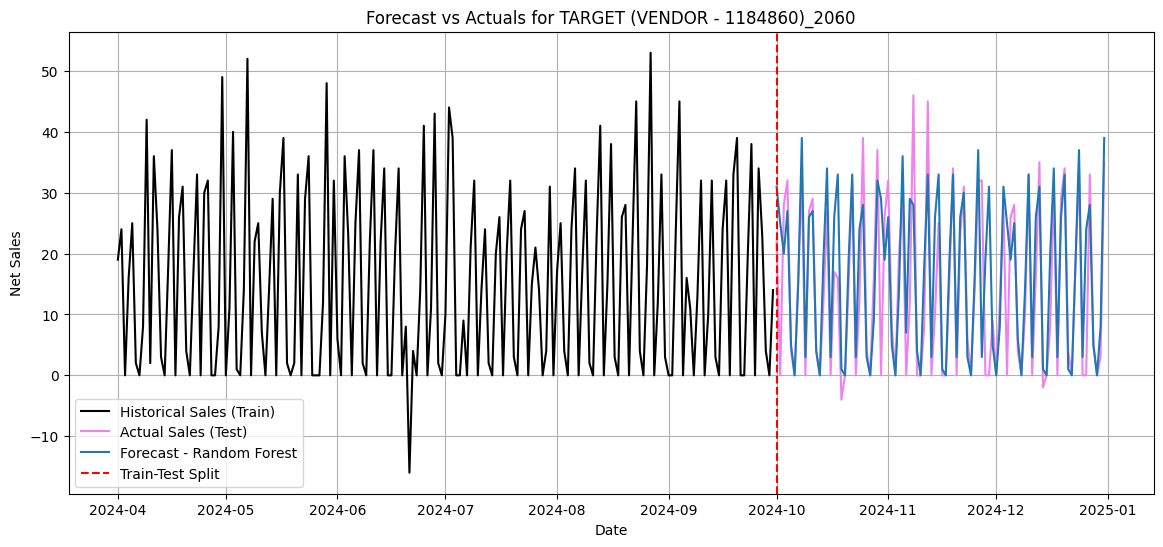

In [ ]:
import matplotlib.pyplot as plt
import random

# Filter for keys with R² ≥ 0.5
filtered_keys = final_results_df[final_results_df['r2'] >= 0.5]['key'].unique()

if len(filtered_keys) == 0:
    print("No keys with R² ≥ 0.5 found.")
else:
    # Randomly select one key
    selected_key = random.choice(filtered_keys)
    print(f"Selected Key for Visualization: {selected_key}")

    # Retrieve all data for this key across different models
    df_selected = final_results_df[final_results_df['key'] == selected_key]

    # Get the train data
    train_data = maindf[(maindf['key'] == selected_key) & (maindf['date'] < train_cutoff) & (maindf['date'] >= '2024-04-01') ]

    # Plot the data
    plt.figure(figsize=(14, 6))

    # Plot historical sales (training data)
    plt.plot(train_data['date'], train_data['netsales'], label="Historical Sales (Train)", color='black')

    # Plot actual sales in the test period
    plt.plot(df_selected['date'], df_selected['actuals'], label="Actual Sales (Test)", color='violet')

    # Plot forecasted sales for each model in different colors
    for model in df_selected['model'].unique():
        model_df = df_selected[df_selected['model'] == model]
        plt.plot(model_df['date'], model_df['predictions'], label=f"Forecast - {model}")

    # Formatting
    plt.axvline(x=train_cutoff, color='red', linestyle='--', label="Train-Test Split")
    plt.xlabel("Date")
    plt.ylabel("Net Sales")
    plt.title(f"Forecast vs Actuals for {selected_key}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585495 entries, 0 to 585494
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UNNAMED:_0                585495 non-null  int64  
 1   ROUTENO                   585495 non-null  int64  
 2   ROUTE_DESCRIPTION         585495 non-null  object 
 3   Full Date                 585495 non-null  object 
 4   FORMATTEDDATE             585495 non-null  object 
 5   SKU                       585495 non-null  int64  
 6   SKU_DESCRIPTION           585495 non-null  object 
 7   Retailer                  585495 non-null  object 
 8   CUSTOMER_ACCT             585495 non-null  object 
 9   STORE_ADDRESS             585495 non-null  object 
 10  STORE_CITY                585495 non-null  object 
 11  STORE_STATE               585495 non-null  object 
 12  GROSS_DOLLARS             585495 non-null  float64
 13  RETURN_DOLLARS            585495 non-null  f

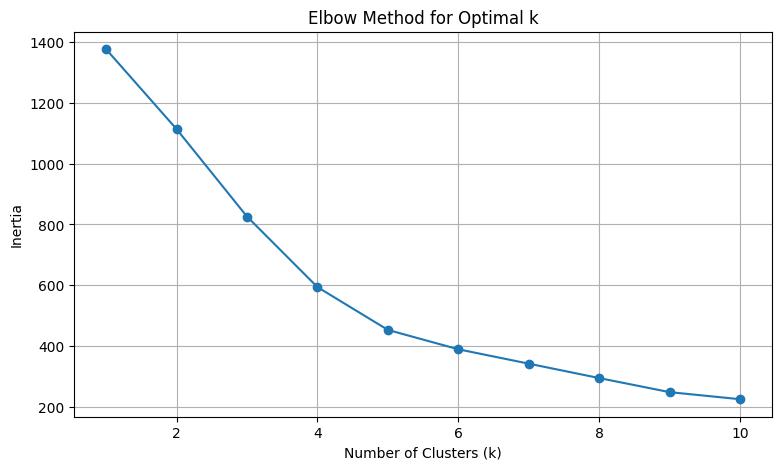


Cluster Profiles:



,Avg_Weekly_Sales_Dollars,Avg_Weekly_Returns_Dollars,Promotion_Spend,Total_Gross_Dollars,Total_Return_Dollars,Avg_Weekly_Return_Rate,Sales_Percent_Contribution,Returns_Percent_Contribution
Cluster,,,,,,,,
0,296.758666,28.856832,7.028027,7715.725306,750.277619,0.108721,0.002426,0.001895
1,1275.009843,37.100577,0.000000,33150.255909,964.615000,0.030593,0.010421,0.002437
2,145.456312,42.529157,19.235205,3781.864110,1105.758082,0.317146,0.001189,0.002793
3,238.642797,27.538485,570.518485,6204.712727,716.000606,0.116821,0.001951,0.001809
4,466.397770,89.204420,0.034783,12126.342029,2319.314928,0.204419,0.003812,0.005858


In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Convert 'Full Date' to datetime format
df['Full Date'] = pd.to_datetime(df['Full Date'])

# Filter for the desired timeframe: Q3 2024 to Q4 2024
start_date = '2024-07-01'
end_date = '2024-12-31'
df_filtered = df[(df['Full Date'] >= start_date) & (df['Full Date'] <= end_date)]

# Group by Store Address and aggregate key metrics
store_features = df_filtered.groupby('STORE_ADDRESS').agg(
    Avg_Weekly_Sales_Dollars=('GROSS_DOLLARS', lambda x: x.sum() / 26),  # 26 weeks from July to Dec
    Avg_Weekly_Returns_Dollars=('RETURN_DOLLARS', lambda x: x.sum() / 26),
    Promotion_Spend=('TRADE_DOLLARS', 'sum'),
    Total_Gross_Dollars=('GROSS_DOLLARS', 'sum'),
    Total_Return_Dollars=('RETURN_DOLLARS', 'sum'),
    Retailer=('Retailer', 'first')
).reset_index()

# Calculate Avg Weekly Return Rate with zero division handling
store_features['Avg_Weekly_Return_Rate'] = store_features.apply(
    lambda row: row['Avg_Weekly_Returns_Dollars'] / row['Avg_Weekly_Sales_Dollars']
    if row['Avg_Weekly_Sales_Dollars'] != 0 else 0, axis=1
)

# Calculate Sales % Contribution and Returns % Contribution
total_sales = store_features['Total_Gross_Dollars'].sum()
total_returns = store_features['Total_Return_Dollars'].sum()

store_features['Sales_Percent_Contribution'] = (
    store_features['Total_Gross_Dollars'] / total_sales)

store_features['Returns_Percent_Contribution'] = (
    store_features['Total_Return_Dollars'] / total_returns)

# Select final features for clustering
final_features = store_features[[
    'Avg_Weekly_Sales_Dollars', 'Avg_Weekly_Returns_Dollars', 'Promotion_Spend',
    'Avg_Weekly_Return_Rate']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features)

# Determine optimal clusters using Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
# Plot Elbow Curve
plt.figure(figsize=(9, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply K-Means with optimal k (based on the elbow curve)
optimal_k = 5  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
store_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Display cluster profiles
cluster_profiles = store_features.groupby('Cluster').mean(numeric_only=True)
print("\nCluster Profiles:\n")
cluster_profiles

In [32]:
# Ensure retailer column exists
if 'Retailer' not in store_features.columns:
    print("Column 'Retailer' not found. Please check the dataset.")
else:
    # Group by Retailer and Cluster, summing Total_Gross_Dollars
    retailer_sales = store_features.groupby(['Retailer', 'Cluster']).agg(
        Total_Gross_Dollars=('Total_Gross_Dollars', 'sum')
    ).reset_index()

    # Sort by Cluster and Total_Gross_Dollars in descending order
    retailer_sales_sorted = retailer_sales.sort_values(
        by=['Cluster', 'Total_Gross_Dollars'], ascending=[True, False]
    )

    # Get top 3 retailers per cluster
    top_3_retailers_per_cluster = retailer_sales_sorted.groupby('Cluster').head(3)

    # Display results
    print(top_3_retailers_per_cluster)



                       Retailer  Cluster  Total_Gross_Dollars
8                  KING SOOPERS        0            710864.22
13                 SAFEWAY (CO)        0            159040.25
30      WHOLE FOODS MARKET (CO)        0            116609.51
4                   COSTCO (CO)        1            477418.75
31      WHOLE FOODS MARKET (CO)        1            139605.78
27              VITAMIN COTTAGE        1             64516.59
14                 SAFEWAY (CO)        2            161452.69
9                  KING SOOPERS        2             65296.86
28              VITAMIN COTTAGE        2             28200.71
25    TARGET (VENDOR - 1184860)        3            118625.26
22          SUPER WAL-MART (CO)        3             86130.26
19  SPROUTS FARMERS MARKET (CO)        4            330502.41
29              VITAMIN COTTAGE        4            236628.68
15                 SAFEWAY (CO)        4             95306.97


In [33]:
retailers_per_cluster = retailer_sales.groupby('Cluster')['Retailer'].nunique()
print(retailers_per_cluster)


Cluster
0    13
1     5
2     6
3     2
4     7
Name: Retailer, dtype: int64
